#                                                     SNA Project


#                GENERATING TRUST NETWORKS AND ANALYSING THEM


# By, 
#        AVINASH V (01FB15ECS061)
#        G MANASA (01FB15ECS099)
#        G SAMEER (01FB15ECS101)

We have used two datasets from the SNAP dataset

# 1) Bitcoin OTC trust weighted signed network

This is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin OTC. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. This is the first explicit weighted signed directed network available for research.

No. of nodes = 5,881
No. of edges = 35,592
Weights in the graph = -10 to +10

# 2) Wikipedia Requests for Adminship (with text)

For a Wikipedia editor to become an administrator, a request for adminship (RfA) must be submitted, either by the candidate or by another community member. Subsequently, any Wikipedia member may cast a supporting, neutral, or opposing vote. This induces a directed, signed network in which nodes represent Wikipedia members and edges represent votes.

No. of nodes = 10,835
No. of edges = 159,388
Weights in the graph = 1,-1,0

In [1]:
# Importing the required packages
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import re

# Data Preprocessing and visualisation -- bitcoin

In [2]:
df = pd.read_csv("1.csv")

# We will add a column to make this a signed network,
# Let us assign 1 if Rating > 4
#               0 otherwise
df['weight'] = [0 if df.iloc[i]['Rating'] < 1 else 1 for i in range(len(df))]
print(df)

       Source  Target  Rating        Time  weight
0           6       2       4  1289241912       1
1           6       5       2  1289241942       1
2           1      15       1  1289243140       1
3           4       3       7  1289245277       1
4          13      16       8  1289254254       1
5          13      10       8  1289254301       1
6           7       5       1  1289362700       1
7           2      21       5  1289370557       1
8           2      20       5  1289370622       1
9          21       2       5  1289380982       1
10         21       1       8  1289441411       1
11         21      10       8  1289441438       1
12         21       8       9  1289441451       1
13         21       3       7  1289441526       1
14         17       3       5  1289442313       1
15         17      23       1  1289489668       1
16         10       1       8  1289555656       1
17         10       6       7  1289555731       1
18         10      21       8  1289555746       1


# Generating a GML graph from csv:

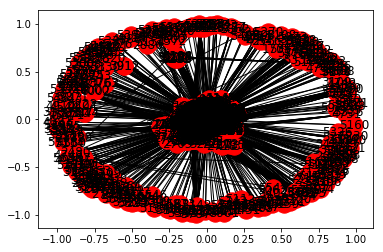

In [3]:
# Forming the whole graph from the dataset
nodes_full = list(set(df['Source']).union(set(df['Target'])))

edges_full = [[df.iloc[i]['Source'],df.iloc[i]['Target'],df.iloc[i]['weight']] for i in range(len(df))]


fp1 = open("bitcoin_full.gml",'w')
fp1.write("graph\n[\n  multigraph 1\n")
for i in nodes_full:
    fp1.write("  node\n  [\n    id "+str(i)+"\n  ]\n")
    
for i in edges_full:
    fp1.write("  edge\n  [\n    source "+str(i[0]))
    fp1.write("\n    target "+str(i[1]))
    fp1.write("\n    weight "+str(i[2])+"\n  ]\n")
fp1.write("\n]") 
fp1.close()

G_orig_bitcoin = nx.read_gml("bitcoin_full.gml",label='id')
nx.draw_networkx(G_orig_bitcoin)
plt.show()

# Splitting into train and test data

In [4]:
# To get the training data, we divide it according to time taking 70% as the training data
# Split according to time and using 80% of it as training graph

df_train = df[df['Time'] < df['Time'].quantile(0.7)]
print(len(df_train)/len(df))
print(df_train)

0.6999866506474436
       Source  Target  Rating        Time  weight
0           6       2       4  1289241912       1
1           6       5       2  1289241942       1
2           1      15       1  1289243140       1
3           4       3       7  1289245277       1
4          13      16       8  1289254254       1
5          13      10       8  1289254301       1
6           7       5       1  1289362700       1
7           2      21       5  1289370557       1
8           2      20       5  1289370622       1
9          21       2       5  1289380982       1
10         21       1       8  1289441411       1
11         21      10       8  1289441438       1
12         21       8       9  1289441451       1
13         21       3       7  1289441526       1
14         17       3       5  1289442313       1
15         17      23       1  1289489668       1
16         10       1       8  1289555656       1
17         10       6       7  1289555731       1
18         10      21       8  

# GML for training data

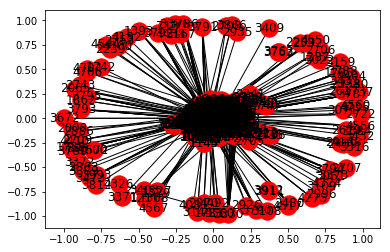

In [5]:
# To create the gml file from df_train:
nodes_train = list(set(df_train['Source']).union(set(df_train['Target'])))

edges_train = [[df_train.iloc[i]['Source'],df_train.iloc[i]['Target'],df_train.iloc[i]['weight']] for i in range(len(df_train))]

fp1 = open("bitcoin_train.gml",'w')
fp1.write("graph\n[\n  multigraph 1\n")
for i in nodes_train:
    fp1.write("  node\n  [\n    id "+str(i)+"\n  ]\n")
    
for i in edges_train:
    fp1.write("  edge\n  [\n    source "+str(i[0]))
    fp1.write("\n    target "+str(i[1]))
    fp1.write("\n    weight "+str(i[2])+"\n  ]\n")
fp1.write("\n]") 
fp1.close()

G_train_bitcoin = nx.read_gml("bitcoin_train.gml",label='id')
nx.draw_networkx(G_train_bitcoin)
plt.show()

# The algorithm developed:



# Intution behind the algo:

    1) When a user i joins the network, he begins interacting with other users randomly. 
    
    2) If user i's interaction with user j is positive, 
                then over time i discovers the users that j knows. 
                
    3) Now, if i trusts j then i will trust anyone that j trusts.
    
    4) However,he won’t automatically start distrusting everyone that j distrusts 
        but the likelihood that i will trust user k will go down if j distrusts k. 
        
    5) On the other hand, if i does not think highly of j,
                then he will automatically form negative edges with everyone that j distrusts.
                
# The algorithm:


for i = 1 to n do
    Pick a node j uniformly at random from {1,2....i-1}
    Create edge (i; j)
    Label the edge + with prob. p, and – with prob. (1 - p)
    for all neighbors k of j do
        if (i; j) is + then
            Create edge (i; k) with prob. rp.
            if (j; k) is + then
                Label edge (i; k) +.
            else
                Label edge (i; k) + or – with prob. 1/2.
            end if
        else
            if (j; k) is – then
                Create edge (i; k) with prob. rn.
                Label edge (i; k) –.
            end if
        end if
    end for
end for


# Defining p

In [6]:
nodes = nx.nodes(G_train_bitcoin)
edges = nx.edges(G_train_bitcoin)


# To select with probability 'p'
# 'p' is the prob of +ve edges
a = df_train.groupby('weight').size()

#print(type(a))
print(a)
#print(a[1])

p = a[1]/(a[0]+a[1])
print('probability of positive edges = ',p)

weight
0     1911
1    24307
dtype: int64
probability of positive edges =  0.9271111450148752


# Defining rp and rn

In [7]:
edge_weights_for_new = list(np.random.choice([0, 1], size=len(nodes), p=[0.11,0.89]))

#rp is fraction of neighbours of j, that i discovers given that (i,j) is + . 
#rn is the fraction of neighbours of j, that i discovers given that (i,j) is - .
rp = 0.75
rn = 0.23
#len(edge_weights_for_new)
print(len(nx.nodes(G_train_bitcoin)))
print(len(nx.edges(G_train_bitcoin)))
print(len(edge_weights_for_new))

4596
26218
4596


# Algo implementation

In [8]:
import random
for i in range(3,len(nodes)):
    #Pick a node j uniformly at random from {1....i-1}
    j = random.randrange(1,i-1)
    #Create edge (i; j)
    G_train_bitcoin.add_edge(i,j)
    #Label the edge + with prob. p, and – with prob. (1-p)
    index_for_new_weight = random.randint(0,len(edge_weights_for_new)-1)

    if(edge_weights_for_new[index_for_new_weight] == 1):
        G_train_bitcoin[i][j][0]['weight'] = 1
    else:
        G_train_bitcoin[i][j][0]['weight'] = 0
        
    neighb_j = G_train_bitcoin.neighbors(j)
    edges_rp = list(np.random.choice([0, 1], size=len(list(neighb_j)), p=[1-rp,rp]))
    edges_rn = list(np.random.choice([0, 1], size=len(list(neighb_j)), p=[1-rn,rn]))
    list_prob_equal = [0,1]
    
    #for all neighbors k of j do
    for k in neighb_j:
        # If (i,j) is +ve
        if(edge_weights_for_new[index_for_new_weight] == 1):
            # Create edge (i; k) with prob. rp.
            create_ik_or_not = random.randint(0,len(list(neighb_j)))
            if(edges_rp[create_ik_or_not] == 1):
                G_train_bitcoin.add_edge(i,k)
            # If (j,k) is +ve
            if(G_train_bitcoin[j][k] == 1):
                # label edge (i,k) as +ve
                G_train_bitcoin[i][k][0]['weight'] = 1
            else:
                # Label edge (i; k) + or – with prob. 1/2.
                index_ik = random.randint(0,len(list_prob_equal))
                if(list_prob_equal[index_ik] == 1):
                    G_train_bitcoin[i][k][0]['weight'] = 1
                else:
                    G_train_bitcoin[i][k][0]['weight'] = 0
                
                
        # If (i,j) is -ve
        else:
            # Create edge (i; k) with prob. rn.
            create_ik_or_not = random.randint(0,len(list(neighb_j)))
            if(edges_rp[create_ik_or_not] == 1):
                G_train_bitcoin.add_edge(i,k)
            # label (i,k) -ve
            G_train_bitcoin[i][k][0]['weight'] = 0
      

In [9]:
G_predicted = G_train_bitcoin

# Getting triadic statistics for checking accuracy

# Counts of diff types of triads in predicted graph

In [10]:
# To compare how the algo performed, we will compare the triadic statistics as follows
G_predicted=nx.to_directed(G_predicted)
triads_t = nx.triadic_census(G_predicted)

#no of triads
print("The sum of each type of triads:")
triads_t

The sum of each type of triads:


{'003': 17398642654,
 '012': 0,
 '102': 92622726,
 '021D': 0,
 '021U': 0,
 '021C': 0,
 '111D': 0,
 '111U': 0,
 '030T': 0,
 '030C': 0,
 '201': 994866,
 '120D': 0,
 '120U': 0,
 '120C': 0,
 '210': 0,
 '300': 17270}

# Ratios of diff types of triads for predicted graph

In [11]:
ratios_of_triads_t = []
sum_triads_t = sum(triads_t.values()) 

for i in triads_t.keys():
    ratios_of_triads_t.append((i,(triads_t[i]/sum_triads_t)))
    
print("The ratios of each type of traids:")
ratios_of_triads_t

The ratios of each type of traids:


[('003', 0.9946470742923925),
 ('012', 0.0),
 ('102', 0.005295063831183731),
 ('021D', 0.0),
 ('021U', 0.0),
 ('021C', 0.0),
 ('111D', 0.0),
 ('111U', 0.0),
 ('030T', 0.0),
 ('030C', 0.0),
 ('201', 5.6874583603536284e-05),
 ('120D', 0.0),
 ('120U', 0.0),
 ('120C', 0.0),
 ('210', 0.0),
 ('300', 9.872928201718338e-07)]

# Counts of diff types of triads in original graph

In [12]:
# Lets get the same statistics for the original graph to see how the algo performed

G_orig=nx.to_directed(G_orig_bitcoin)
triads_f = nx.triadic_census(G_orig)

#no of triads
print("The sum of each type of triads:")
triads_f

The sum of each type of triads:


{'003': 33758216573,
 '012': 0,
 '102': 123065040,
 '021D': 0,
 '021U': 0,
 '021C': 0,
 '111D': 0,
 '111U': 0,
 '030T': 0,
 '030C': 0,
 '201': 1595914,
 '120D': 0,
 '120U': 0,
 '120C': 0,
 '210': 0,
 '300': 33493}

# Ratios of diff types of triads in original graph

In [13]:
ratios_of_triads_f = []
sum_triads_f = sum(triads_f.values()) 

for i in triads_f.keys():
    ratios_of_triads_f.append((i,(triads_f[i]/sum_triads_f)))
    
print("The ratios of each type of traids:")
ratios_of_triads_f

The ratios of each type of traids:


[('003', 0.9963198425623349),
 ('012', 0.0),
 ('102', 0.003632068092595664),
 ('021D', 0.0),
 ('021U', 0.0),
 ('021C', 0.0),
 ('111D', 0.0),
 ('111U', 0.0),
 ('030T', 0.0),
 ('030C', 0.0),
 ('201', 4.7100852670479904e-05),
 ('120D', 0.0),
 ('120U', 0.0),
 ('120C', 0.0),
 ('210', 0.0),
 ('300', 9.884923990217414e-07)]

# Getting RMSE and r2_score to measure accuracy

In [14]:
# To quantify the performance of the algo, let's define "Accuracy" wrt to the ratios of triads as :
y_actual = []
y_predicted = []

for i in range(len(ratios_of_triads_f)):
    y_actual.append(ratios_of_triads_f[i][1])
    y_predicted.append(ratios_of_triads_t[i][1])

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

rms = sqrt(mean_squared_error(y_actual, y_predicted))
print('RMSE = ',rms)

r2 = r2_score(y_actual, y_predicted)
print('r2 = ',r2)   

RMSE =  0.0005896929305423366
r2 =  0.9999940184854014


# Visualisation on both the generated and original graphs

# Degree distributuion histogram for predicted graph

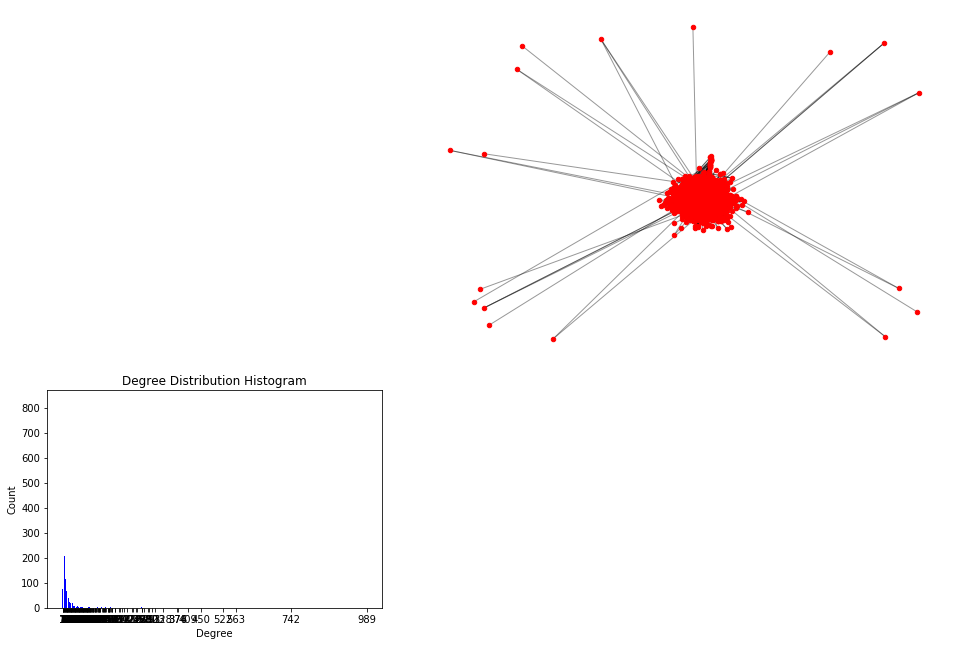

In [15]:
import collections

degree_sequence = sorted([d for n, d in G_train_bitcoin.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Distribution Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([1, 1, 1.2, 1.2])
Gcc = sorted(nx.connected_component_subgraphs(G_train_bitcoin), key=len, reverse=True)[0]
pos = nx.spring_layout(G_train_bitcoin)
plt.axis('off')
nx.draw_networkx_nodes(G_train_bitcoin, pos, node_size=20)
nx.draw_networkx_edges(G_train_bitcoin, pos, alpha=0.4)

plt.show()

# Degree distributuion histogram for original graph

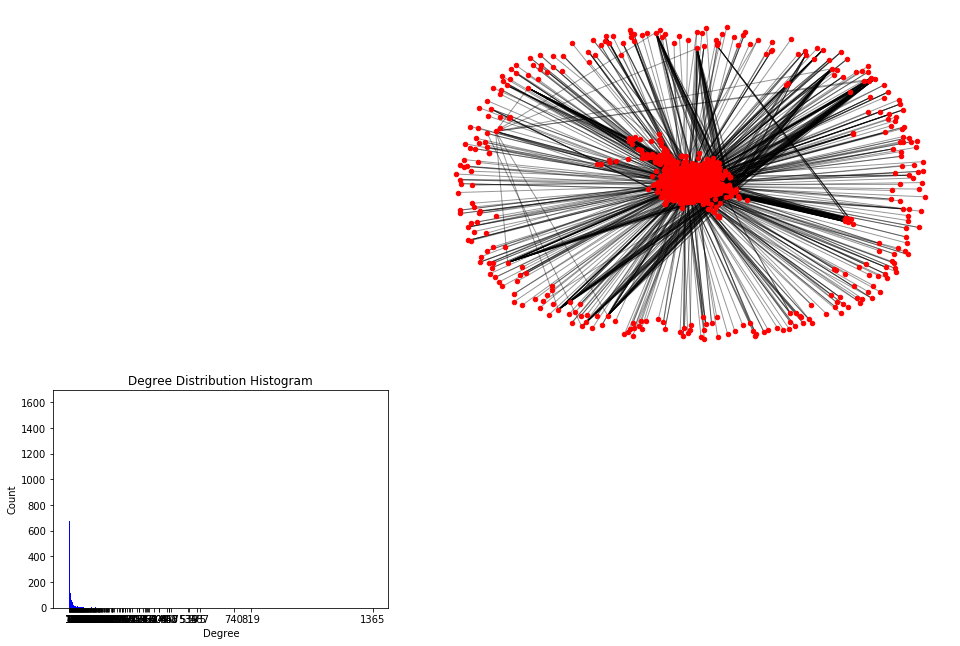

In [18]:
import collections

degree_sequence = sorted([d for n, d in G_orig_bitcoin.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Distribution Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([1, 1, 1.2, 1.2])
Gcc = sorted(nx.connected_component_subgraphs(G_orig_bitcoin), key=len, reverse=True)[0]
pos = nx.spring_layout(G_orig_bitcoin)
plt.axis('off')
nx.draw_networkx_nodes(G_orig_bitcoin, pos, node_size=20)
nx.draw_networkx_edges(G_orig_bitcoin, pos, alpha=0.4)

plt.show()

# Log-log plot for predicted graph

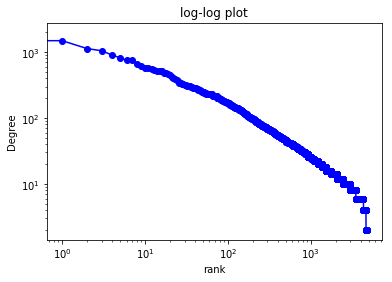

In [19]:
import collections

degree_sequence = sorted([d for n, d in G_predicted.degree()], reverse=True)  # degree sequence

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("log-log plot")
plt.ylabel("Degree")
plt.xlabel("rank")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.savefig("log-log-predicted.png")
plt.show()

# Log-log plot for original graph

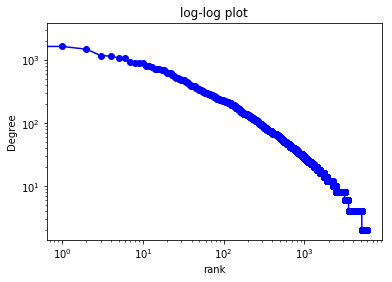

In [20]:
import collections

degree_sequence = sorted([d for n, d in G_orig.degree()], reverse=True)  # degree sequence

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("log-log plot")
plt.ylabel("Degree")
plt.xlabel("rank")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.savefig("log-log-original.png")
plt.show()

# degree rank plot for predicted graph

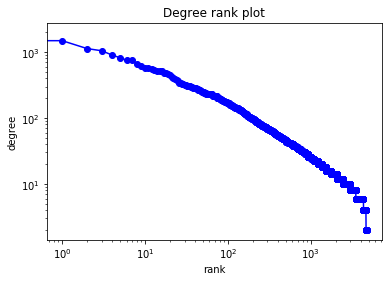

In [21]:
degree_sequence = sorted([d for n, d in G_predicted.degree()], reverse=True) 
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.savefig("degree_rank_predicted.png")
plt.show()

# degree rank plot for original graph

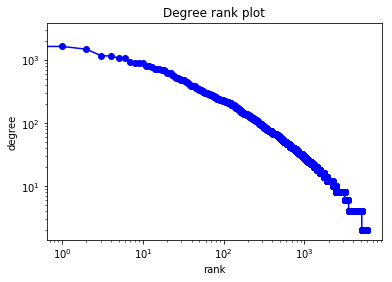

In [22]:
degree_sequence = sorted([d for n, d in G_orig.degree()], reverse=True) 
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.savefig("degree_rank_original.png")
plt.show()

# Plots wrt accuracy

In [23]:
# Getting all the labels
actual_f = []
actual_f_labels = []
predicted_f = []
predicted_f_labels = []
for i in ratios_of_triads_f:
    if i[1] != 0.0:
        actual_f.append(i[1])
        actual_f_labels.append(i[0])
for i in ratios_of_triads_t:
    if i[1] != 0.0:
        predicted_f.append(i[1])
        predicted_f_labels.append(i[0])
print(actual_f , actual_f_labels)
print(predicted_f , predicted_f_labels)

[0.9963198425623349, 0.003632068092595664, 4.7100852670479904e-05, 9.884923990217414e-07] ['003', '102', '201', '300']
[0.9946470742923925, 0.005295063831183731, 5.6874583603536284e-05, 9.872928201718338e-07] ['003', '102', '201', '300']


# Scores by ratio of triads and type

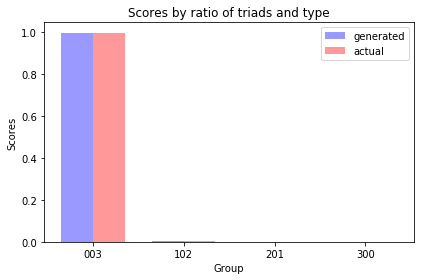

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


n_groups = 4

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, predicted_f, bar_width,
                alpha=opacity, color='b',
                label='generated')

rects2 = ax.bar(index + bar_width, actual_f, bar_width,
                alpha=opacity, color='r',
                label='actual')

ax.set_xlabel('Group')
ax.set_ylabel('Scores')
ax.set_title('Scores by ratio of triads and type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(actual_f_labels)
ax.legend()

fig.tight_layout()
plt.show()

# log(no of triads)

In [25]:
#log scores are plotted for each type of triads
import math
actual_scores_f = []
actual_scores_f_labels = []
predicted_scores_f = []
predicted_scores_f_labels = []
for k,v in triads_f.items():
    if triads_f[k] != 0:
        actual_scores_f.append(math.log(v))
        actual_scores_f_labels.append(k)
for k,v in triads_t.items():
    if triads_t[k] != 0:
        predicted_scores_f.append(math.log(v))
        predicted_scores_f_labels.append(k)
print(actual_scores_f , actual_scores_f_labels)
print(predicted_scores_f , predicted_scores_f_labels)

[24.242489678649644, 18.628223554069358, 14.28295717082828, 10.419091740755093] ['003', '102', '201', '300']
[23.579658031733278, 18.344045090671866, 13.810363333704624, 9.756726171140725] ['003', '102', '201', '300']


# Scores by triad type and no of triads

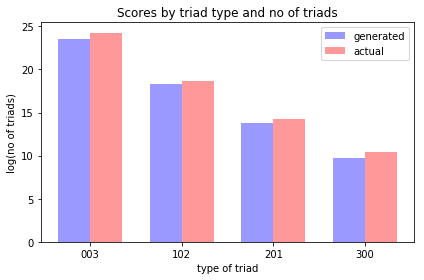

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


n_groups = 4

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, predicted_scores_f, bar_width,
                alpha=opacity, color='b',
                label='generated')

rects2 = ax.bar(index + bar_width, actual_scores_f, bar_width,
                alpha=opacity, color='r',
                label='actual')

ax.set_xlabel('type of triad')
ax.set_ylabel('log(no of triads)')
ax.set_title('Scores by triad type and no of triads')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(actual_scores_f_labels)
ax.legend()

fig.tight_layout()
plt.show()

# Now we will use the WIKIPEDIA text data to do the same

# Data Preprocessing and visualisation -- wiki

In [27]:
from datetime import datetime
import pandas as pd
f = open("wiki-Rfa.txt",encoding="utf8")

sources = []
targets = []
votes = []
results = []
years = []
dates = []
texts = []
for line in f:
    if(line[0:3] == "SRC"):
        sources.append(line[4:].strip('\n'))
    if(line[0:3] == "TGT"):
        targets.append(line[4:].strip('\n'))
    if(line[0:3] == "VOT"):
        votes.append(line[4:].strip('\n'))
    if(line[0:3] == "RES"):
        results.append(line[4:].strip('\n'))
    if(line[0:3] == "YEA"):
        years.append(line[4:].strip('\n'))
    if(line[0:3] == "DAT"):
            dat = line[4:]
            if len(dat) == 1:
                dates.append(0)
            else:
                dat = re.split(':|, | |\n',dat)
                month = {"Jan":"01","Janry" : "01","January" : "01","Feb" : "02","February" : "02","March" : "03","Mar" : "03","Apr" : "04","April" : "04","Mya" : "05","May" : "05","June" : "06","Jun" : "06","Julu" : "07","July" : "07","Jul":"07","Aug":"08","August" : "08","Sep" : "09","September" : "09","October" : 10,"Oct" : 10,"Nov": 11,"November" : 11,"December" : 12,"Dec":12 }
                x = dat[2]
                if int(dat[2]) < 10:
                    x = str(0) + str(dat[2])
                dat = str(dat[4]) + str(month[dat[3]]) + str(x) + str(dat[0]) + str(dat[1])
                dat = int(dat)
                dates.append(dat)
    if(line[0:3] == "TXT"):
        texts.append(line[4:].strip('\n'))
        
df = pd.DataFrame()
df['src'] = sources
df['tgt'] = targets
df['vote'] = votes
df['res'] = results
df['year'] = years
df['date'] = dates
df['txt'] = texts

df = df[df.date != 0]
df['weight'] = [0 if int(df.iloc[i]['vote']) in [0,-1] else 1 for i in range(len(df))]
df

,src,tgt,vote,res,year,date,txt,weight
0,Steel1943,BDD,1,1,2013,201304192313,'''Support''' as co-nom.,1
1,Cuchullain,BDD,1,1,2013,201304200104,'''Support''' as nominator.--,1
2,INeverCry,BDD,1,1,2013,201304192343,'''Support''' per noms.,1
3,Cncmaster,BDD,1,1,2013,201304200011,'''Support''' per noms. BDD is a strong contri...,1
4,Miniapolis,BDD,1,1,2013,201304200056,"'''Support''', with great pleasure. I work wit...",1
5,Sven Manguard,BDD,1,1,2013,201304200153,'''Support''' There are plenty of important ro...,1
6,Ramaksoud2000,BDD,1,1,2013,201304200200,'''Support''' per noms. I don't see a reason n...,1
7,RockMagnetist,BDD,1,1,2013,201304200218,'''Support''' BDD already wields a broom pret...,1
8,Carrite,BDD,1,1,2013,201304200222,'''Support''' barring a completely unexpected ...,1
9,Someguy1221,BDD,1,1,2013,201304200309,'''Support''' because I see no good reason not...,1


# Generating GML from txt file

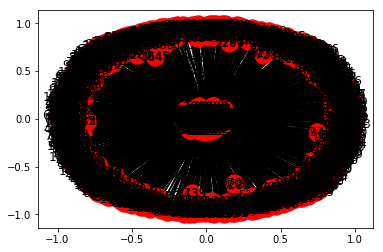

In [28]:
nodes_full = list(set(df['src']).union(set(df['tgt'])))
len(nodes_full)

edges_full = [[df.iloc[i]['src'],df.iloc[i]['tgt'],df.iloc[i]['vote']] for i in range(len(df))] 

# Considering neutral vote as -ve edge

fp1 = open("wiki_Rfa_full_final.gml",'w',encoding="utf8")
fp1.write("graph\n[\n  multigraph 1\n")
for i in nodes_full:
    fp1.write("  node\n  [\n    id "+str(nodes_full.index(i)+1)+"\n  ]\n")
    
for i in edges_full:
    fp1.write("  edge\n  [\n    source "+str(nodes_full.index(i[0])+1))
    fp1.write("\n    target "+str(nodes_full.index(i[1])+1))
    if int(i[2]) in [-1,0]:
        fp1.write("\n    weight 0\n  ]\n")
    else:
        fp1.write("\n    weight 1\n  ]\n")
fp1.write("\n]") 
fp1.close()


G_orig_wiki = nx.read_gml("wiki_Rfa_full_final.gml",label='id')
nx.draw_networkx(G_orig_wiki)
plt.show()

# Splitting into training and test data

In [29]:
# Split according to time and using 80% of it as training graph

df_train = df[df['date'] < df['date'].quantile(0.8)]
print(len(df_train)/len(df))
print(df_train)

0.7999978825671755
                          src           tgt vote res  year          date  \
32777                  Shappy   AdjustShift    1   1  2009  200904042018   
32778         Jake Wartenberg   AdjustShift    1   1  2009  200904042021   
32779                  GT5162   AdjustShift    1   1  2009  200904042021   
32780                Giants27   AdjustShift    1   1  2009  200904042026   
32781               America69   AdjustShift    1   1  2009  200904042039   
32782                 Carioca   AdjustShift    1   1  2009  200904042213   
32783                   Erik9   AdjustShift    1   1  2009  200904042237   
32784             Pastor Theo   AdjustShift    1   1  2009  200904042248   
32785   Faithlessthewonderboy   AdjustShift    1   1  2009  200904042256   
32786                 Fastily   AdjustShift    1   1  2009  200904050011   
32787             Malinaccier   AdjustShift    1   1  2009  200904050057   
32788              Aaroncrick   AdjustShift    1   1  2009  200904050

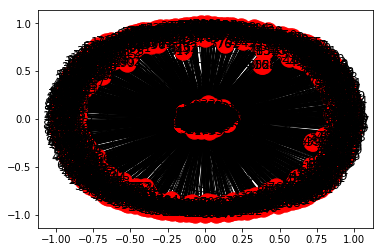

In [30]:
nodes_train = list(set(df_train['src']).union(set(df_train['tgt'])))
len(nodes_train)

edges_train = [[df_train.iloc[i]['src'],df_train.iloc[i]['tgt'],df_train.iloc[i]['vote']] for i in range(len(df_train))] 

# Considering neutral vote as -ve edge

fp1 = open("wiki_Rfa_train.gml",'w',encoding="utf8")
fp1.write("graph\n[\n  multigraph 1\n")
for i in nodes_train:
    fp1.write("  node\n  [\n    id "+str(nodes_train.index(i)+1)+"\n  ]\n")
    
for i in edges_train:
    fp1.write("  edge\n  [\n    source "+str(nodes_train.index(i[0])+1))
    fp1.write("\n    target "+str(nodes_train.index(i[1])+1))
    if int(i[2]) in [-1,0]:
        fp1.write("\n    weight 0\n  ]\n")
    else:
        fp1.write("\n    weight 1\n  ]\n")
fp1.write("\n]") 
fp1.close()

G_train_wiki = nx.read_gml("wiki_Rfa_train.gml",label='id')
nx.draw_networkx(G_train_wiki)
plt.show()

# Defining p

In [31]:
nodes = nx.nodes(G_train_wiki)
edges = nx.edges(G_train_wiki)


# To select with probability 'p'
# 'p' is the prob of +ve edges
a = df_train.groupby('weight').size()

#print(type(a))
print(a)
#print(a[1])

p = a[1]/(a[0]+a[1])
print('probability of positive edges = ',p)

weight
0     39930
1    111196
dtype: int64
probability of positive edges =  0.7357833860487275


# Defining rp and rn

In [32]:
edge_weights_for_new = list(np.random.choice([0, 1], size=len(nodes), p=[0.11,0.89]))

#rp is fraction of neighbours of j, that i discovers given that (i,j) is + . 
#rn is the fraction of neighbours of j, that i discovers given that (i,j) is - .
rp = 0.75
rn = 0.23
#len(edge_weights_for_new)
print(len(nx.nodes(G_train_wiki)))
print(len(nx.edges(G_train_wiki)))
print(len(edge_weights_for_new))

9183
151126
9183


# Implementation of algo

In [33]:
import random
for i in range(3,len(nodes)):
    #Pick a node j uniformly at random from {1....i-1}
    j = random.randrange(1,i-1)
    #Create edge (i; j)
    G_train_wiki.add_edge(i,j)
    #Label the edge + with prob. p, and – with prob. (1-p)
    index_for_new_weight = random.randint(0,len(edge_weights_for_new)-1)
    
    if(edge_weights_for_new[index_for_new_weight] == 1):
        G_train_wiki[i][j][0]['weight'] = 1
    else:
        G_train_wiki[i][j][0]['weight'] = 0
        
    neighb_j = G_train_wiki.neighbors(j)
    edges_rp = list(np.random.choice([0, 1], size=len(list(neighb_j)), p=[1-rp,rp]))
    edges_rn = list(np.random.choice([0, 1], size=len(list(neighb_j)), p=[1-rn,rn]))
    list_prob_equal = [0,1]
    
    #for all neighbors k of j do
    for k in neighb_j:
        # If (i,j) is +ve
        if(edge_weights_for_new[index_for_new_weight] == 1):
            # Create edge (i; k) with prob. rp.
            create_ik_or_not = random.randint(0,len(list(neighb_j)))
            if(edges_rp[create_ik_or_not] == 1):
                G_train_wiki.add_edge(i,k)
            # If (j,k) is +ve
            if(G_train_wiki[j][k] == 1):
                # label edge (i,k) as +ve
                G_train_wiki[i][k][0]['weight'] = 1
            else:
                # Label edge (i; k) + or – with prob. 1/2.
                index_ik = random.randint(0,len(list_prob_equal))
                if(list_prob_equal[index_ik] == 1):
                    G_train_wiki[i][k][0]['weight'] = 1
                else:
                    G_train_wiki[i][k][0]['weight'] = 0
                
                
        # If (i,j) is -ve
        else:
            # Create edge (i; k) with prob. rn.
            create_ik_or_not = random.randint(0,len(list(neighb_j)))
            if(edges_rp[create_ik_or_not] == 1):
                G_train_wiki.add_edge(i,k)
            # label (i,k) -ve
            G_train_wiki[i][k][0]['weight'] = 0
            

# Sum of triads in predicted graph

In [34]:
# To compare how the algo performed, we will compare the triadic statistics as follows
G1=nx.to_directed(G_train_wiki)
triads_t = nx.triadic_census(G1)

#no of triads
print("The sum of each type of triads:")
triads_t

The sum of each type of triads:


{'003': 127680370572,
 '012': 0,
 '102': 1320001456,
 '021D': 0,
 '021U': 0,
 '021C': 0,
 '111D': 0,
 '111U': 0,
 '030T': 0,
 '030C': 0,
 '201': 19663751,
 '120D': 0,
 '120U': 0,
 '120C': 0,
 '210': 0,
 '300': 1025452}

# Ratios of triads in predicted graph

In [35]:
ratios_of_triads_t = []
sum_triads_t = sum(triads_t.values()) 

for i in triads_t.keys():
    ratios_of_triads_t.append((i,(triads_t[i]/sum_triads_t)))
    
print("The ratios of each type of traids:")
ratios_of_triads_t

The ratios of each type of traids:


[('003', 0.9896087456868796),
 ('012', 0.0),
 ('102', 0.010230899074970887),
 ('021D', 0.0),
 ('021U', 0.0),
 ('021C', 0.0),
 ('111D', 0.0),
 ('111U', 0.0),
 ('030T', 0.0),
 ('030C', 0.0),
 ('201', 0.00015240729546313307),
 ('120D', 0.0),
 ('120U', 0.0),
 ('120C', 0.0),
 ('210', 0.0),
 ('300', 7.947942686380678e-06)]

# Sum of triads in original graph

In [36]:
# Lets get the same statistics for the original graph to see how the algo performed
# Let's get only the training graph and try to generate the whole graph
G_orig = nx.read_gml("wiki_Rfa_full_final.gml",label='id')

G1=nx.to_directed(G_orig)
triads_f = nx.triadic_census(G1)

#no of triads
print("The sum of each type of triads:")
triads_f

The sum of each type of triads:


{'003': 227756102603,
 '012': 0,
 '102': 1885184670,
 '021D': 0,
 '021U': 0,
 '021C': 0,
 '111D': 0,
 '111U': 0,
 '030T': 0,
 '030C': 0,
 '201': 25165620,
 '120D': 0,
 '120U': 0,
 '120C': 0,
 '210': 0,
 '300': 1340111}

# Ratios of triads in original graph

In [37]:
ratios_of_triads_f = []
sum_triads_f = sum(triads_f.values()) 

for i in triads_f.keys():
    ratios_of_triads_f.append((i,(triads_f[i]/sum_triads_f)))
    
print("The ratios of each type of traids:")
ratios_of_triads_f

The ratios of each type of traids:


[('003', 0.9916762800042812),
 ('012', 0.0),
 ('102', 0.008208310992770182),
 ('021D', 0.0),
 ('021U', 0.0),
 ('021C', 0.0),
 ('111D', 0.0),
 ('111U', 0.0),
 ('030T', 0.0),
 ('030C', 0.0),
 ('201', 0.000109574005439943),
 ('120D', 0.0),
 ('120U', 0.0),
 ('120C', 0.0),
 ('210', 0.0),
 ('300', 5.834997508669663e-06)]

# RMSE and r2_score for measuring accuracy

In [38]:
# To quantify the performance of the algo, let's define "Accuracy" wrt to the ratios of triads as :
y_actual = []
y_predicted = []

for i in range(len(ratios_of_triads_f)):
    y_actual.append(ratios_of_triads_f[i][1])
    y_predicted.append(ratios_of_triads_t[i][1])

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

rms = sqrt(mean_squared_error(y_actual, y_predicted))
print('RMSE = ',rms)

r2 = r2_score(y_actual, y_predicted)
print('r2 = ',r2)

RMSE =  0.0007231614558297609
r2 =  0.9999909147690746


# Degree distribution histogram for predicted graph

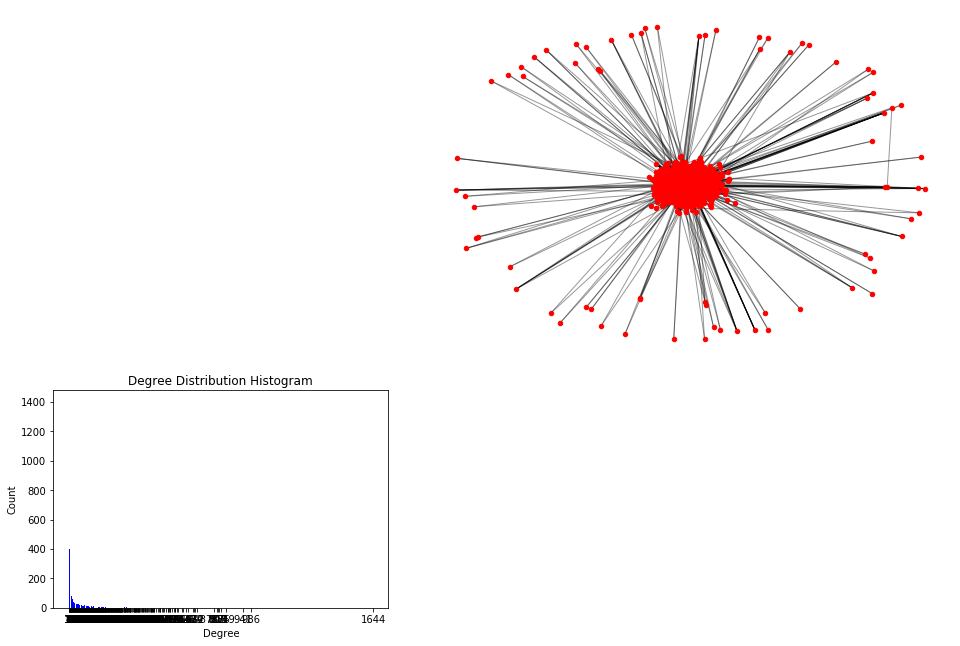

In [39]:
import collections

degree_sequence = sorted([d for n, d in G_train_wiki.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Distribution Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([1, 1, 1.2, 1.2])
Gcc = sorted(nx.connected_component_subgraphs(G_train_wiki), key=len, reverse=True)[0]
pos = nx.spring_layout(G_train_wiki)
plt.axis('off')
nx.draw_networkx_nodes(G_train_wiki, pos, node_size=20)
nx.draw_networkx_edges(G_train_wiki, pos, alpha=0.4)

plt.show()

# Degree distribution histogram for original graph

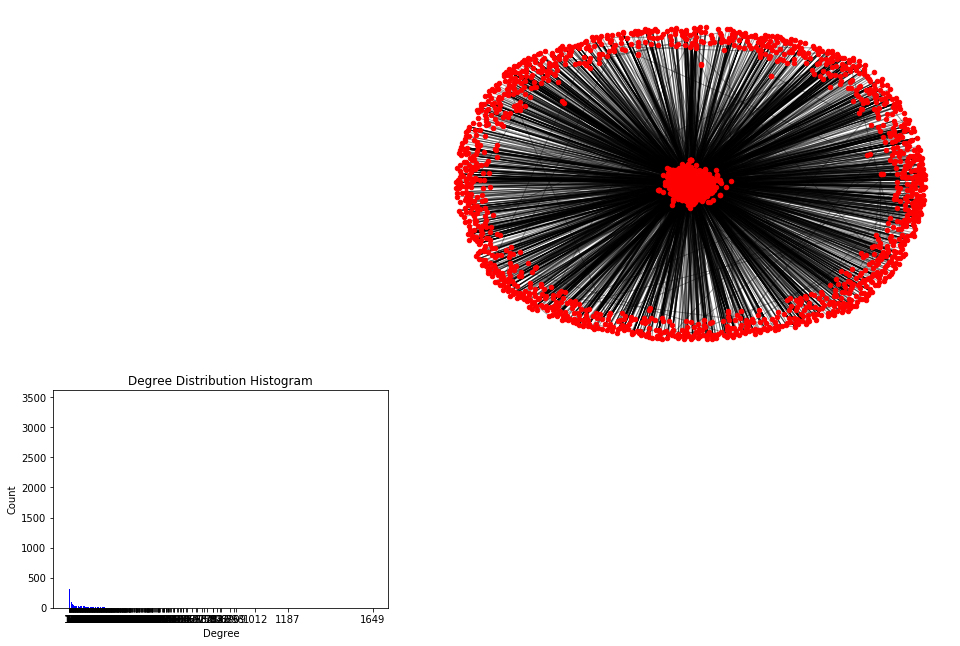

In [40]:
import collections

degree_sequence = sorted([d for n, d in G_orig_wiki.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Distribution Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([1, 1, 1.2, 1.2])
Gcc = sorted(nx.connected_component_subgraphs(G_orig_wiki), key=len, reverse=True)[0]
pos = nx.spring_layout(G_orig_wiki)
plt.axis('off')
nx.draw_networkx_nodes(G_orig_wiki, pos, node_size=20)
nx.draw_networkx_edges(G_orig, pos, alpha=0.4)

plt.show()

# Log-log plot for predicted graph

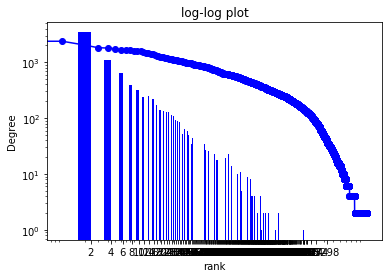

In [41]:
import collections

degree_sequence = sorted([d for n, d in G1.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("log-log plot")
plt.ylabel("Degree")
plt.xlabel("rank")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

plt.savefig("log-log-predicted_b.png")
plt.show()

# Log-log plot for original graph

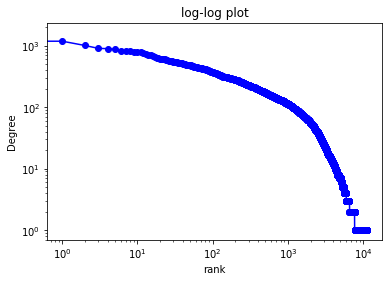

In [42]:
import collections

degree_sequence = sorted([d for n, d in G_orig.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
# degreeCount = collections.Counter(degree_sequence)
# deg, cnt = zip(*degreeCount.items())

# fig, ax = plt.subplots()
# plt.bar(deg, cnt, width=0.80, color='b')
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("log-log plot")
plt.ylabel("Degree")
plt.xlabel("rank")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

plt.savefig("log-log-predicted_w.png")
plt.show()

# Degree-rank plot for predicted graph

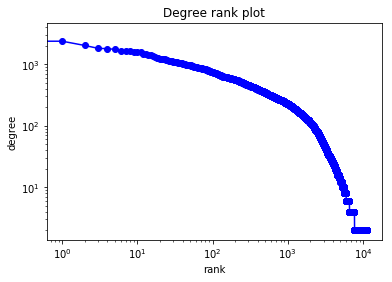

In [43]:
degree_sequence = sorted([d for n, d in G1.degree()], reverse=True)  # degree sequence#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

plt.savefig("degree-rank-original_w.png")
plt.show()

# Degree-rank plot for original graph

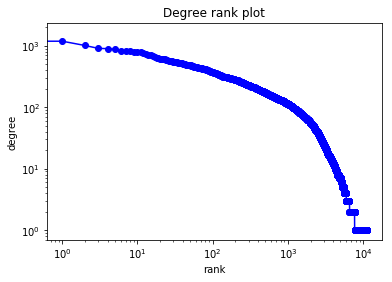

In [44]:
degree_sequence = sorted([d for n, d in G_orig.degree()], reverse=True)  # degree sequence#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

plt.savefig("degree-rank-original_w.png")
plt.show()

# Getting the labels

In [45]:
actual_f = []
actual_f_labels = []
predicted_f = []
predicted_f_labels = []
for i in ratios_of_triads_f:
    if i[1] != 0.0:
        actual_f.append(i[1])
        actual_f_labels.append(i[0])
for i in ratios_of_triads_t:
    if i[1] != 0.0:
        predicted_f.append(i[1])
        predicted_f_labels.append(i[0])
print(actual_f , actual_f_labels)
print(predicted_f , predicted_f_labels)

[0.9916762800042812, 0.008208310992770182, 0.000109574005439943, 5.834997508669663e-06] ['003', '102', '201', '300']
[0.9896087456868796, 0.010230899074970887, 0.00015240729546313307, 7.947942686380678e-06] ['003', '102', '201', '300']


# Accuracy measure plots

# Scores by ratio of triads and type

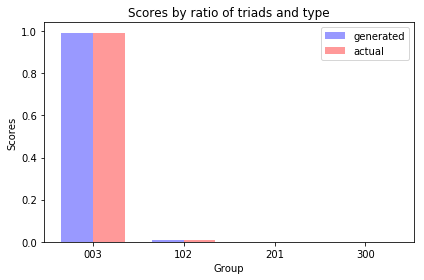

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


n_groups = 4

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, predicted_f, bar_width,
                alpha=opacity, color='b',
                label='generated')

rects2 = ax.bar(index + bar_width, actual_f, bar_width,
                alpha=opacity, color='r',
                label='actual')

ax.set_xlabel('Group')
ax.set_ylabel('Scores')
ax.set_title('Scores by ratio of triads and type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(actual_f_labels)
ax.legend()

fig.tight_layout()
plt.show()

# Log(scores)

In [47]:
#log scores are plotted for each type of triads
import math
actual_scores_f = []
actual_scores_f_labels = []
predicted_scores_f = []
predicted_scores_f_labels = []
for k,v in triads_f.items():
    if triads_f[k] != 0:
        actual_scores_f.append(math.log(v))
        actual_scores_f_labels.append(k)
for k,v in triads_t.items():
    if triads_t[k] != 0:
        predicted_scores_f.append(math.log(v))
        predicted_scores_f_labels.append(k)
print(actual_scores_f , actual_scores_f_labels)
print(predicted_scores_f , predicted_scores_f_labels)

[26.15154116791081, 21.35729162121758, 17.04098933528231, 14.108263004317292] ['003', '102', '201', '300']
[25.57279587299332, 21.000898676574387, 16.79428744797385, 13.840644048963233] ['003', '102', '201', '300']


# Scores by triad type and no of triads

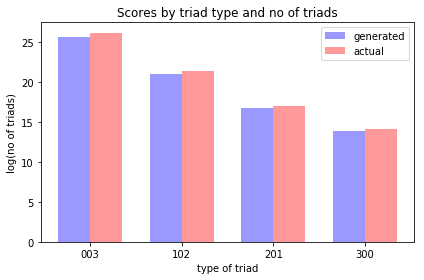

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


n_groups = 4

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, predicted_scores_f, bar_width,
                alpha=opacity, color='b',
                label='generated')

rects2 = ax.bar(index + bar_width, actual_scores_f, bar_width,
                alpha=opacity, color='r',
                label='actual')

ax.set_xlabel('type of triad')
ax.set_ylabel('log(no of triads)')
ax.set_title('Scores by triad type and no of triads')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(actual_scores_f_labels)
ax.legend()

fig.tight_layout()
plt.show()